# Mean Shift Clustering

In [32]:
import numpy as np
import cv2 as cv
from sklearn.cluster import MeanShift, estimate_bandwidth
from mpl_toolkits import mplot3d
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

import polars as pl

Mean shift is similar to Kmeans clustering, but instead of having the centroid be at the mean of all the points in the cluster, the centroid is placed at the position where there is the most density of cluster points.

This is done by calculateing a weighted mean over the neighborhood of each point.

The advantage of this algorithm is that it only requires a single parameter, the size of the neighborhood over which to find the weighted average. The algorithm will automatically find the number of clusters needed.

Unfortunately there is no easy way of choosing the correct window size in all cases. The algorithm can also be slow to run since it might need a lot of iterations before converging.

## Mean shift image segmentation

We'll once again be working on image data to illustrate clustering.

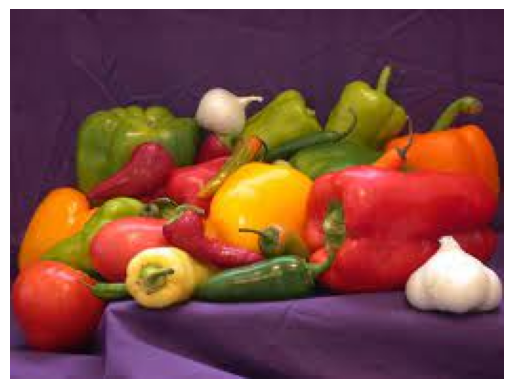

In [15]:
img = cv.imread('./data/peppers2.jpeg')
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.axis('off');

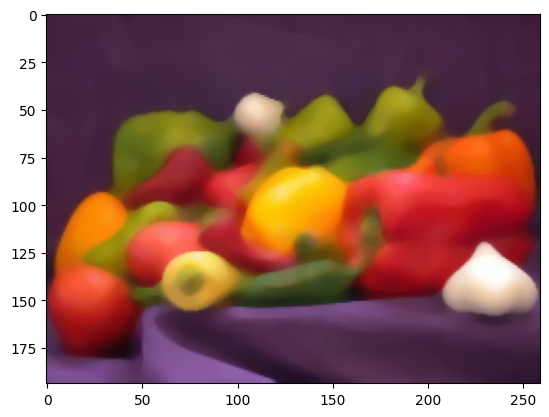

In [13]:
# Use open CV to smooth the image
img = cv.medianBlur(img, 7)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB));

The image is encoded in `BGR` format, so for plotting we need to convert it using openCV. When we plot a distribution of colors in 3D space we'll also have to be careful about labelling the axes.

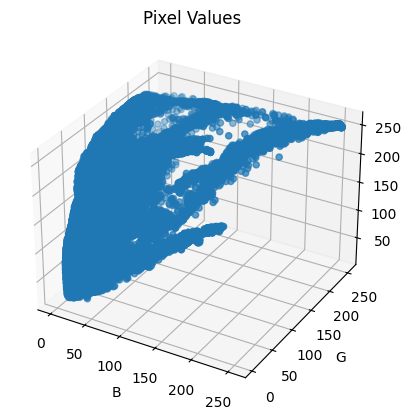

In [12]:
ax = plt.axes(projection ="3d")
ax.scatter3D(img[:,:,0],img[:,:,1],img[:,:,2])
ax.set_title('Pixel Values ')
ax.set_xlabel("B")
ax.set_ylabel("G")
ax.set_zlabel("R")
plt.show()

Then we can format the data into a linear array holding the pixel values as follows:

In [18]:
X = np.float64(img.reshape((-1, 3)))
X.shape

(50246, 3)

### Applying Mean Shift

Before we can apply the Mean Shift algorithm, we have to make a guess for the bandwidth to use in the window size. Luckily there is an `estimate_bandwidth()` function available.

For this we can select the quantile to use (0.5 would be the median), and an amount of damp[les to use in estimation.]

In [ ]:
bw = estimate_bandwidth(X, quantile=.06, n_samples=3000)
bw

np.float64(35.4676625475364)

Which we can then use to initialise the MS model. the `bin_seeding` parameter first bins the data, effectively downsampling the search space.

In [22]:
ms = MeanShift(bandwidth=bw, bin_seeding=True)
ms.fit(X)

,bandwidth,np.float64(35.4676625475364)
,seeds,None
,bin_seeding,True
,min_bin_freq,1
,cluster_all,True
,n_jobs,None
,max_iter,300


After fitting, the algorithm returns a label for each of the pixels, corresponding to the cluster that pixel belongs to. Below we can see that there were 10 clusters found (0-9) and that cluster 0 holds the most pixels.

In [40]:
labels = ms.labels_
labels, pl.DataFrame(np.unique(labels, return_counts=True), schema=["cluster", "counts"])

(array([0, 0, 0, ..., 0, 0, 0], shape=(50246,)),
 shape: (10, 2)
 ┌─────────┬────────┐
 │ cluster ┆ counts │
 │ ---     ┆ ---    │
 │ i64     ┆ i64    │
 ╞═════════╪════════╡
 │ 0       ┆ 24625  │
 │ 1       ┆ 7563   │
 │ 2       ┆ 6866   │
 │ 3       ┆ 2806   │
 │ 4       ┆ 4311   │
 │ 5       ┆ 1427   │
 │ 6       ┆ 428    │
 │ 7       ┆ 501    │
 │ 8       ┆ 1080   │
 │ 9       ┆ 639    │
 └─────────┴────────┘)

We can also inspect the cluster centroids, which in this case correspond to pixel values.

In [27]:
ms.cluster_centers_

array([[ 67.47480583,  37.70041675,  69.88136958],
       [ 31.66513057,  27.4969278 , 172.83410138],
       [ 23.04692892,  95.87025535,  98.54658385],
       [142.36568365,  82.22144772, 126.01662198],
       [ 11.02698962, 120.76678201, 243.74463668],
       [  8.28571429, 182.63945578, 251.303207  ],
       [184.70943396, 210.53962264, 238.74716981],
       [235.42666667, 244.54666667, 251.53904762],
       [159.44337812, 186.93857965, 218.57773512],
       [103.2962963 , 220.94135802, 250.58024691]])

However, the original data was in integer encoded RGB values, so we'll need to convert these to integers again when we want to use them.

In [30]:
img.dtype

dtype('uint8')

Let's build a lookup table for this.

In [39]:
c_lut = pl.DataFrame(ms.cluster_centers_.astype(np.uint8))

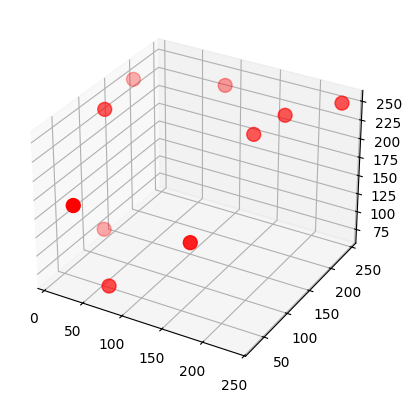

In [50]:
ax = plt.axes(projection ="3d")
#ax.scatter3D(img[:,:,0],img[:,:,1],img[:,:,2])
ax.scatter3D(c_lut[:,0],c_lut[:,1],c_lut[:,2],color='red', s=100)
plt.show()

Which we can then easily use to cluster the entire image

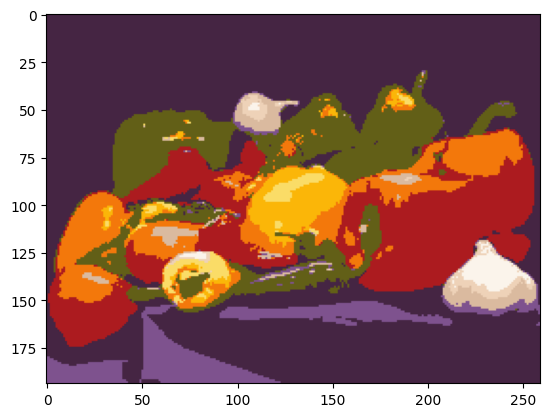

In [54]:
clustered_img = np.array(c_lut[labels]).reshape(img.shape)
plt.imshow(cv.cvtColor(clustered_img, cv.COLOR_BGR2RGB))

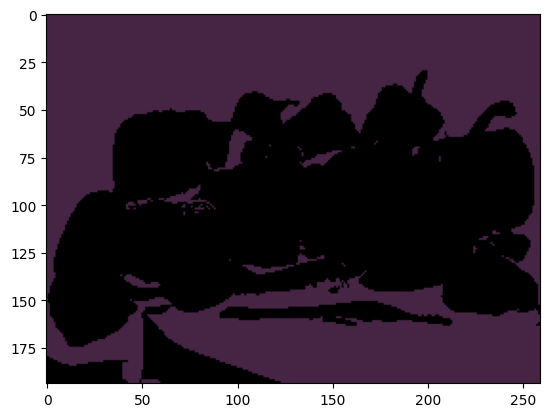

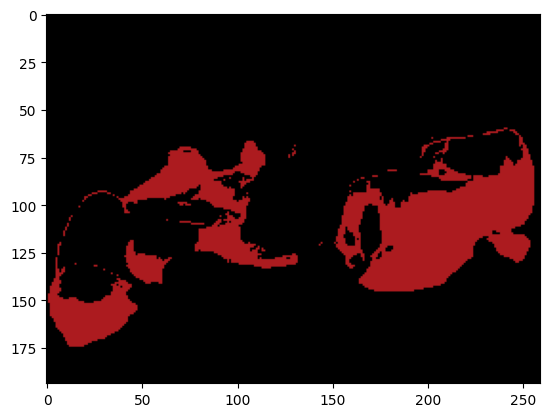

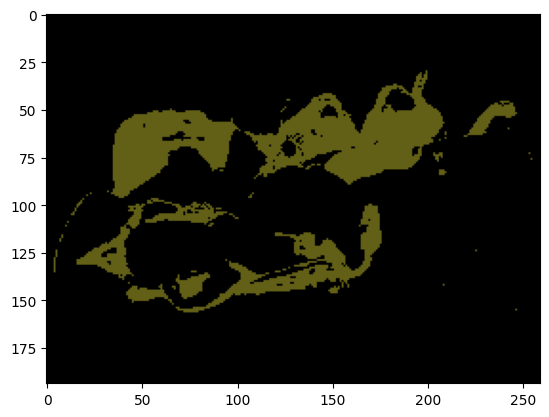

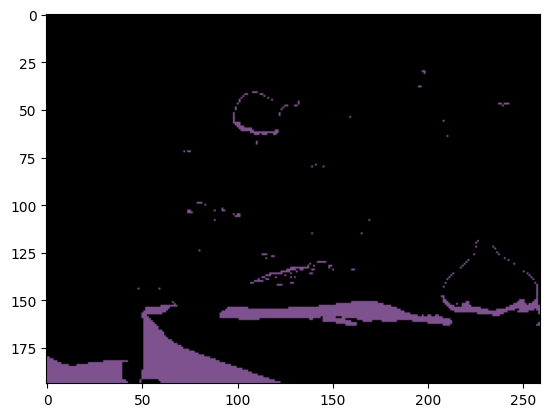

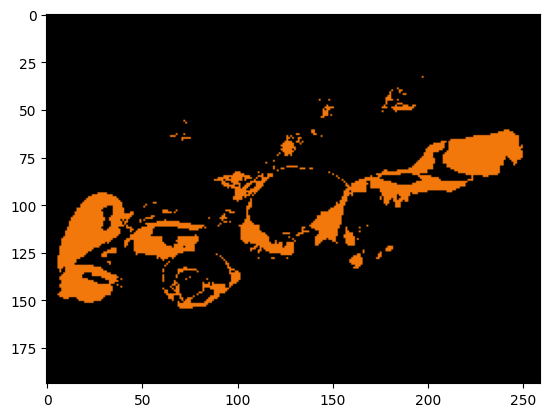

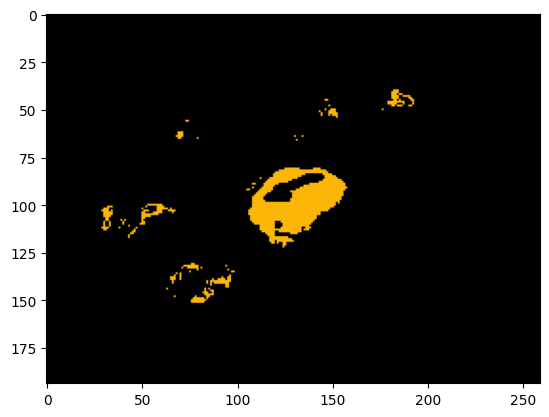

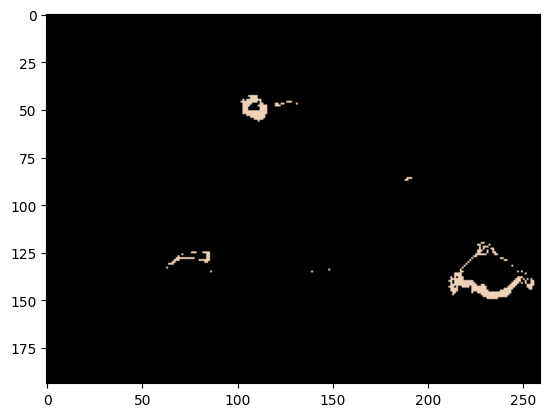

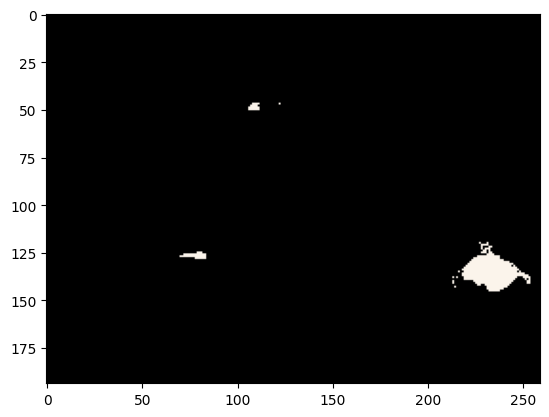

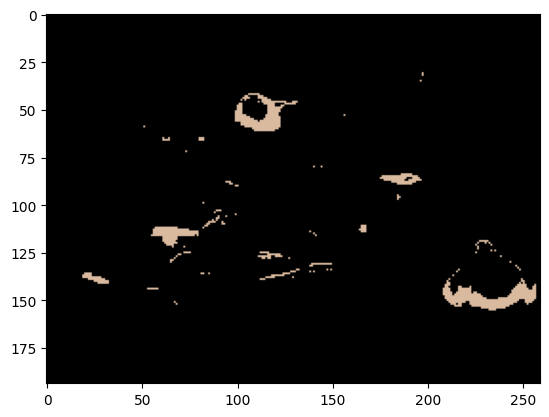

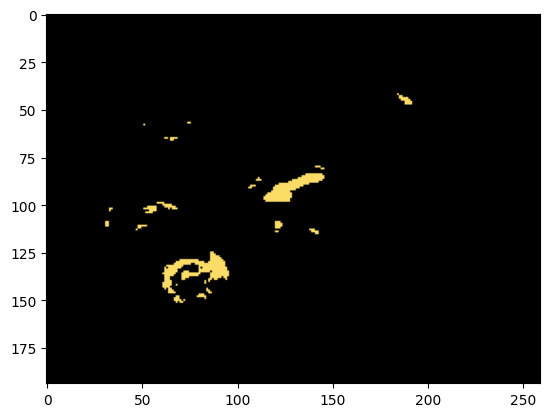

In [58]:
for label in np.unique(labels):
    result=np.zeros(X.shape,dtype=np.uint8)
    result[labels==label, :]=c_lut[int(label)]  
    plt.imshow(cv.cvtColor(result.reshape(img.shape), cv.COLOR_BGR2RGB))
    plt.show()

Here we can clearly see that the clusters have grouped similar colors and, with some more tuning, can be used as a segmentatio tool

## More Image Segementation

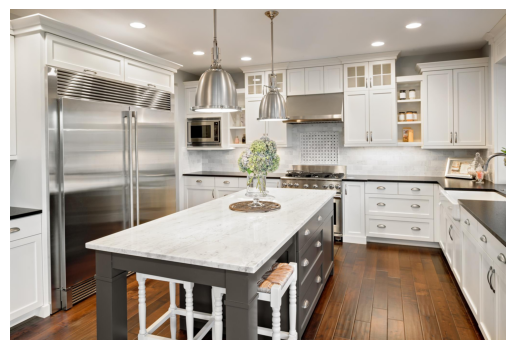

In [60]:
img = cv.imread("./data/slider-image-2.jpg")
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.axis('off');

First, blur the image and reshape it to a linear array of pixels.

Then we estimate a value for the bandwidth, before clustering with MeanShift

In [63]:
X = np.float64(cv.medianBlur(img, 7).reshape((-1, 3)))
bw = estimate_bandwidth(X, quantile=0.1, n_samples=5000)
ms = MeanShift(bandwidth=bw, bin_seeding=True)
ms.fit(X)

,bandwidth,np.float64(25.31237997320942)
,seeds,None
,bin_seeding,True
,min_bin_freq,1
,cluster_all,True
,n_jobs,None
,max_iter,300


Below we can see that the algorithm found 5 clusters

In [66]:
c_lut = pl.DataFrame(ms.cluster_centers_.astype(np.uint8))
labels = ms.labels_
c_lut

column_0,column_1,column_2
u8,u8,u8
210,216,219
168,178,186
62,70,78
82,93,103
50,85,130


We'll use the labels to index into the lookup table and show the resulting image.

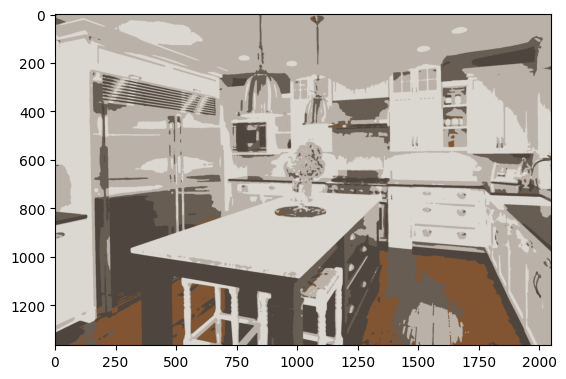

In [65]:
clustered_image = np.array(c_lut[ms.labels_]).reshape(img.shape)
plt.imshow(cv.cvtColor(clustered_image, cv.COLOR_BGR2RGB));

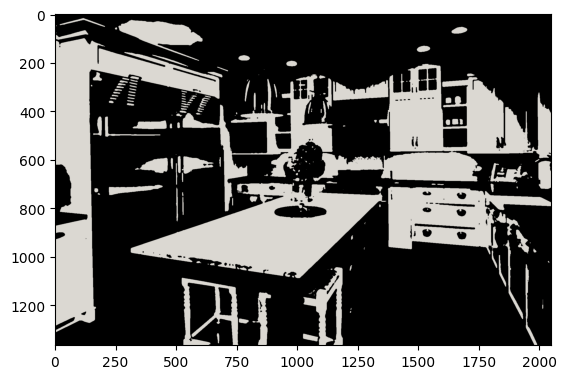

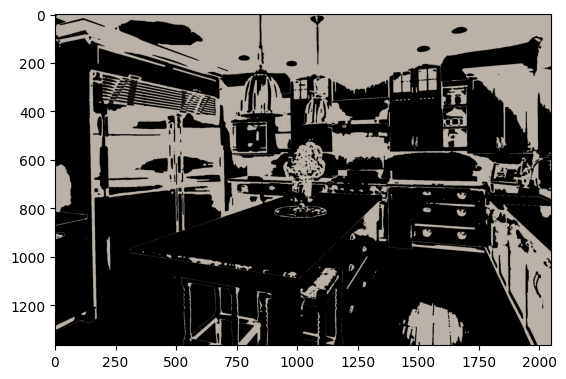

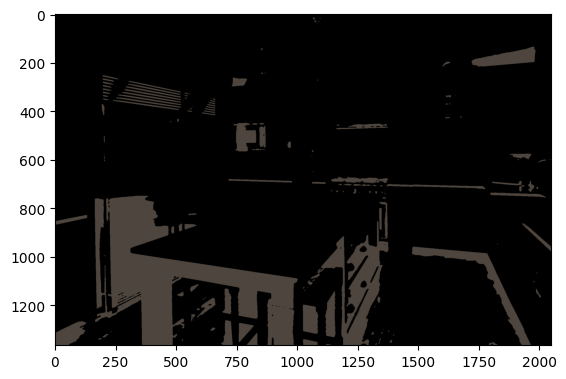

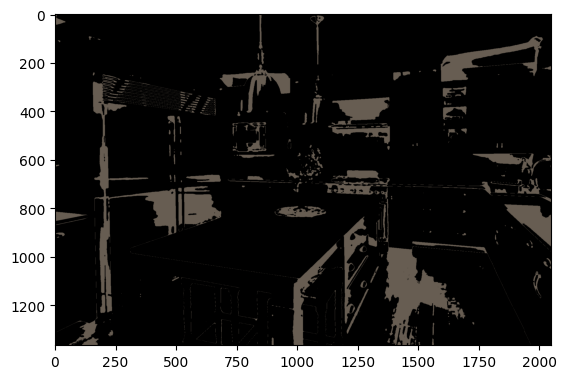

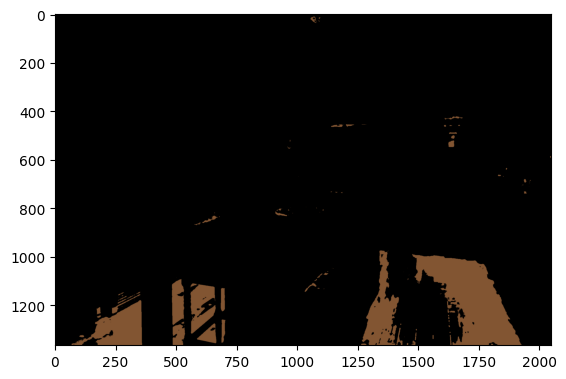

In [67]:
for label in np.unique(labels):
    result=np.zeros(X.shape,dtype=np.uint8)
    result[labels==label, :]=c_lut[int(label)]  
    plt.imshow(cv.cvtColor(result.reshape(img.shape), cv.COLOR_BGR2RGB))
    plt.show()

## Clustering non-image data: Titanic Dataset

<table>
<tbody>
<tr><th><b>Variable</b></th><th><b>Definition</b></th><th><b>Key</b></th></tr>
<tr>
<td>survival</td>
<td>Survival</td>
<td>0 = No, 1 = Yes</td>
</tr>
<tr>
<td>pclass</td>
<td>Ticket class</td>
<td>1 = 1st, 2 = 2nd, 3 = 3rd</td>
</tr>
<tr>
<td>sex</td>
<td>Sex</td>
<td></td>
</tr>
<tr>
<td>Age</td>
<td>Age in years</td>
<td></td>
</tr>
<tr>
<td>sibsp</td>
<td># of siblings / spouses aboard the Titanic</td>
<td></td>
</tr>
<tr>
<td>parch</td>
<td># of parents / children aboard the Titanic</td>
<td></td>
</tr>
<tr>
<td>ticket</td>
<td>Ticket number</td>
<td></td>
</tr>
<tr>
<td>fare</td>
<td>Passenger fare</td>
<td></td>
</tr>
<tr>
<td>cabin</td>
<td>Cabin number</td>
<td></td>
</tr>
<tr>
<td>embarked</td>
<td>Port of Embarkation</td>
<td>C = Cherbourg, Q = Queenstown, S = Southampton</td>
</tr>
</tbody>
</table>


In [81]:
df = pl.read_csv('./data/titanic.csv').drop(['Name','Ticket','Cabin','PassengerId','Embarked'])
df.head()

Survived,Pclass,Sex,Age,SibSp,Parch,Fare
i64,i64,str,f64,i64,i64,f64
0,3,"""male""",22.0,1,0,7.25
1,1,"""female""",38.0,1,0,71.2833
1,3,"""female""",26.0,0,0,7.925
1,1,"""female""",35.0,1,0,53.1
0,3,"""male""",35.0,0,0,8.05


In [82]:
df = df.with_columns(
    pl.col("Sex").cast(pl.Categorical).to_physical()
)
df.head()

Survived,Pclass,Sex,Age,SibSp,Parch,Fare
i64,i64,u32,f64,i64,i64,f64
0,3,0,22.0,1,0,7.25
1,1,1,38.0,1,0,71.2833
1,3,1,26.0,0,0,7.925
1,1,1,35.0,1,0,53.1
0,3,0,35.0,0,0,8.05


In [84]:
df.null_count()

Survived,Pclass,Sex,Age,SibSp,Parch,Fare
u32,u32,u32,u32,u32,u32,u32
0,0,0,177,0,0,0


In [87]:
df = df.with_columns(
    pl.col("Age").fill_null(pl.col("Age").mean())
)
df.null_count()

Survived,Pclass,Sex,Age,SibSp,Parch,Fare
u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0


Then we can split up the data and standardize it.

In [105]:
target = "Survived"
features = list(df.columns)
features.remove(target)

X = df[features].select(
    (pl.all() - pl.all().mean()) / (pl.all().std() + 1e-7)
)
df.shape

(891, 7)

With the data prepared, it is time to apply the clustering with the Mean Shift algorithm. Since there are only 891 samples, we'll use all of them for the bandwidth estimation.

In [115]:
bw = estimate_bandwidth(X)
ms = MeanShift(bandwidth=bw, bin_seeding=True)
ms.fit(X)

,bandwidth,np.float64(2.3759872191771847)
,seeds,None
,bin_seeding,True
,min_bin_freq,1
,cluster_all,True
,n_jobs,None
,max_iter,300


In [116]:
df = df.with_columns(pl.Series("cluster", ms.labels_))

In [117]:
df.group_by('cluster').mean().sort(by=["Survived"])

cluster,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
i64,f64,f64,f64,f64,f64,f64,f64
3,0.0,3.0,0.428571,29.699118,8.0,2.0,69.55
6,0.0,1.0,0.0,61.0,0.5,3.0,188.1375
2,0.333333,2.8,0.8,37.8,0.8,4.0,32.085553
0,0.37388,2.309859,0.3137,30.942901,0.271447,0.183099,24.064953
1,0.392857,2.821429,0.607143,9.701723,2.892857,1.446429,29.987427
4,0.740741,1.0,0.703704,27.752527,0.851852,1.296296,197.723304
5,1.0,1.0,0.333333,35.333333,0.0,0.333333,512.3292


From this clustering we can see that the 7 clusters generated, sorted by survival probability, give some interesting insights.

- The survival rate is generally dependent on the fare paid
- The only outlier here is cluster 6, which has a higher average age.
- The lower survival rate was also for people who had multiple siblings/spouses on board.

Generally, the best survival rate was for richer, younger passengers that were on the ship alone.